# Assignment 2 - Human Value Detection

## Dependencies

In [66]:
# !pip install lightning
# !pip install torchmetrics
# !pip install pandas
# !pip install numpy
# !pip install matplotlib

In [67]:
# file management
import urllib.request
import os
from pathlib import Path

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# torchmetrics
from torchmetrics import PrecisionRecallCurve
from torchmetrics.classification import MultilabelConfusionMatrix

# pytorch lightning
from lightning import LightningModule
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchmetrics.classification import MultilabelF1Score
from torchmetrics import Metric
from torchmetrics import ConfusionMatrix

# transformers
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer

## TASK 1: Corpus

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

### Download the corpus

In [68]:
# download data from url and save it to the data folder

file_names = [
    "arguments-training.tsv",
    "arguments-test.tsv",
    "arguments-validation.tsv",
    "labels-training.tsv",
    "labels-test.tsv",
    "labels-validation.tsv"
]

# Create the data folder
if not os.path.exists("./data"):
    os.makedirs("./data")

url = "https://zenodo.org/records/8248658/files/{file_name}?download=1"
for file_name in file_names:
    if os.path.exists(f"./data/{file_name}"):
        print(f"File {file_name} already exists. Skipping download...")
        continue

    file_url = url.format(file_name=file_name)
    print(f"Downloading {file_name} from {file_url}...")        
    urllib.request.urlretrieve(url.format(file_name=file_name), f"./data/{file_name}")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

File arguments-training.tsv already exists. Skipping download...
File arguments-test.tsv already exists. Skipping download...
File arguments-validation.tsv already exists. Skipping download...
File labels-training.tsv already exists. Skipping download...
File labels-test.tsv already exists. Skipping download...
File labels-validation.tsv already exists. Skipping download...


In [69]:
# Create the dataframes
df_arg_train = pd.read_csv('./data/arguments-training.tsv', sep='\t')
df_arg_test = pd.read_csv('./data/arguments-test.tsv', sep='\t')
df_arg_val = pd.read_csv('./data/arguments-validation.tsv', sep='\t')

df_labels_train = pd.read_csv('./data/labels-training.tsv', sep='\t')
df_labels_test = pd.read_csv('./data/labels-test.tsv', sep='\t')
df_labels_val = pd.read_csv('./data/labels-validation.tsv', sep='\t')

df_labels_test.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A26004,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,A26010,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
2,A26016,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,A26024,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A26026,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0


### Annotations
Since the task requires only to take in account *level 3 categories* a mapping between *level 2* and *level 3* is created.

In [70]:
level_3_categories = ["Openness to change", "Self-enhancement", "Conservation", "Self-transcendence"]

level_3_to_2_mapping = {
    "Openness to change": [
        "Self-direction: thought",
        "Self-direction: action",
        "Stimulation",
        "Hedonism",
    ],
    "Self-enhancement": [
        "Hedonism",
        "Achievement",
        "Power: dominance",
        "Power: resources",
        "Face",
    ],
    "Conservation": [
        "Security: personal",
        "Security: societal",
        "Conformity: rules",
        "Conformity: interpersonal",
        "Tradition",
        "Face",
        "Humility",
    ],
    "Self-transcendence": [
        "Benevolence: caring",
        "Benevolence: dependability",
        "Universalism: concern",
        "Universalism: nature",
        "Universalism: tolerance",
        "Universalism: objectivity",
        "Humility",
    ]
}

column_to_drop = [level_2 for level_3 in level_3_to_2_mapping.values() for level_2 in level_3]

for category in level_3_categories:
    # make a logical OR of all the level 2 categories
    df_labels_test[category] = df_labels_test[level_3_to_2_mapping[category]].any(axis=1).map({True: 1, False: 0})
    df_labels_val[category] = df_labels_val[level_3_to_2_mapping[category]].any(axis=1).map({True: 1, False: 0})
    df_labels_train[category] = df_labels_train[level_3_to_2_mapping[category]].any(axis=1).map({True: 1, False: 0})

df_labels_test = df_labels_test.drop(columns=column_to_drop)
df_labels_val = df_labels_val.drop(columns=column_to_drop)
df_labels_train = df_labels_train.drop(columns=column_to_drop)

df_labels_test.head()

,Argument ID,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A26004,0,1,1,1
1,A26010,0,1,0,1
2,A26016,0,1,1,1
3,A26024,0,1,0,0
4,A26026,0,1,1,1


In [71]:
df_train = pd.merge(df_arg_train, df_labels_train, on='Argument ID')
df_test = pd.merge(df_arg_test, df_labels_test, on='Argument ID')
df_val = pd.merge(df_arg_val, df_labels_val, on='Argument ID')

df_train.head()

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


### Task 1.5 - stance encoding

In [72]:
# Encode stance into 0, 1 
df_train["Stance"] = df_train["Stance"].map({"in favor of": 1, "against": 0})
df_test["Stance"] = df_test["Stance"].map({"in favor of": 1, "against": 0})
df_val["Stance"] = df_val["Stance"].map({"in favor of": 1, "against": 0})

df_train.head()

,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,1,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,1,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,0,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,0,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,0,factory farming allows for the production of c...,0,0,1,1


### Dataset definition

In [73]:
class ArgumentDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "Premise": row["Premise"],
            "Conclusion": row["Conclusion"],
            "labels": torch.tensor(row[level_3_categories].values.tolist(), dtype=torch.float32),
            "Stance": torch.tensor(row["Stance"], dtype=torch.float32)
        }

In [74]:
train_dataset = ArgumentDataset(df_train)
test_dataset = ArgumentDataset(df_test)
val_dataset = ArgumentDataset(df_val)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(train_dataset[0])
print(train_dataset[1])

{'Premise': 'we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.', 'Conclusion': 'We should ban human cloning', 'labels': tensor([0., 0., 1., 0.]), 'Stance': tensor(1.)}
{'Premise': 'fast food should be banned because it is really bad for your health and is costly.', 'Conclusion': 'We should ban fast food', 'labels': tensor([0., 0., 1., 0.]), 'Stance': tensor(1.)}


### Dataset analysis
It is possible to see that almost all labels are unbalanced. This could lead our model to output as prediction the majority class for each label.

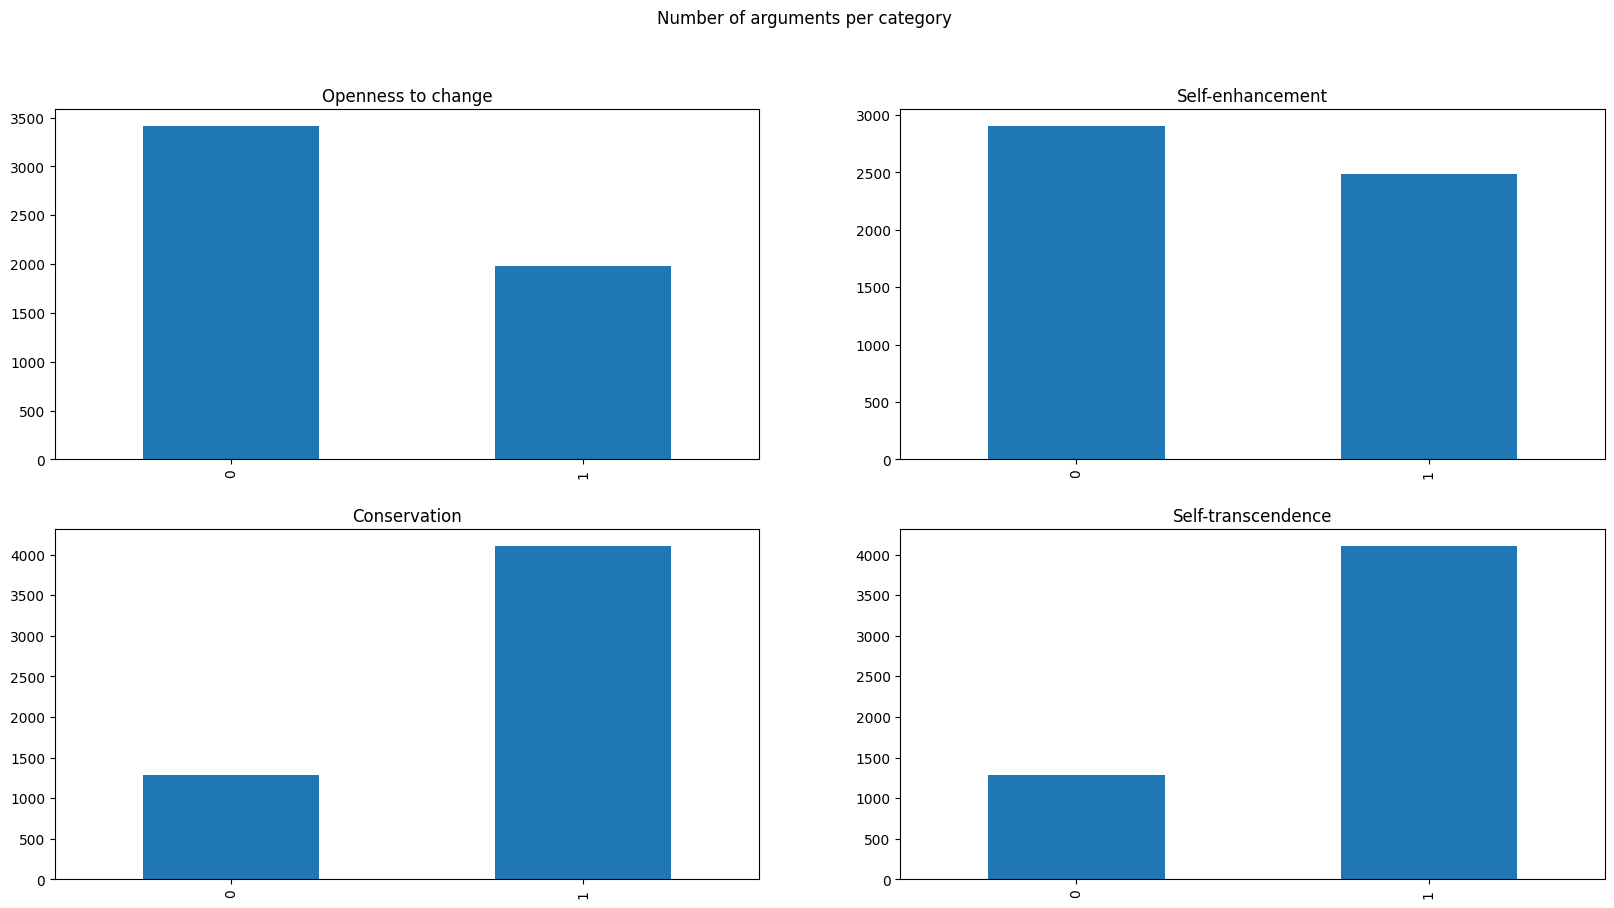

In [75]:
# TODO - remove this

data = []
labels = []
plt.figure(figsize=(20, 10))
plt.suptitle("Number of arguments per category")
for i, level_3 in enumerate(level_3_categories):
    plt.subplot(2, 2, i+1)
    values = df_train[level_3].value_counts().sort_index()
    data.append(values)
    labels.append(level_3)  
    values.plot(kind="bar", title=level_3)

plt.show()

# Global overview
# plt.figure(figsize=(20, 10))
# plt.title("Number of arguments per category")
# plt.bar(labels, list(zip(*data))[1], color=["green"])
# plt.show()

## TASK 3: Metrics

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

In [76]:
class F1ScoreCumulative(Metric):
    def __init__(self, num_classes: int):
        super().__init__()

        self.num_classes = num_classes

        self.add_state("true_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_negative", default=torch.zeros([num_classes]), dist_reduce_fx="sum")
        self.add_state("false_positive", default=torch.zeros([num_classes]), dist_reduce_fx="sum")

    def update(self, y_hat: torch.Tensor, y: torch.Tensor):
        
        for i in range(self.num_classes):
            true_positive = torch.sum((y_hat[:, i] == 1) & (y[:, i] == 1))
            false_negative = torch.sum((y_hat[:, i] == 0) & (y[:, i] == 1))
            false_positive = torch.sum((y_hat[:, i] == 1) & (y[:, i] == 0))

            self.true_positive[i] += true_positive
            self.false_negative[i] += false_negative
            self.false_positive[i] += false_positive

    def compute(self):
        precision = self.true_positive / (self.true_positive + self.false_positive)
        recall = self.true_positive / (self.true_positive + self.false_negative)

        f1 = 2 * (precision * recall) / (precision + recall)
        
        # If there are not enough data to compute the f1 score, set it to 0
        if f1.isnan().any():
            f1[f1.isnan()] = 0

        return f1



## TASK 2: Model definition

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Baselines: random uniform classifier and majority classifier

In [77]:
# TODO - check if this is correct or we need to define 4 different models
class RandomUniformClassifier(LightningModule):
    def __init__(self):
        self._random_state = np.random.RandomState()

    def predict(self, X):
        batch_size = X.shape[0]
        logits = self._random_state.uniform(size=(batch_size, 4))
        logits = logits > 0.5
        return torch.tensor(logits, dtype=torch.float32)


class MajorityClassifier(LightningModule):
    def __init__(self, n_random_classifiers=10):
        self.n_random_classifiers = n_random_classifiers
        self.random_classifiers = [RandomUniformClassifier() for _ in range(n_random_classifiers)]

    def predict(self, X):
        batch_size = X.shape[0]
        votes = torch.zeros((batch_size, 4))
        for clf in self.random_classifiers:
            votes += clf.predict(X)
        votes = votes / self.n_random_classifiers
        votes = votes > 0.5
        return torch.tensor(votes, dtype=torch.float32)

In [78]:
# Function for loading the backbon given the name
def load_backbone(backbone_name):
    if backbone_name == "bert-base-uncased":
        backbone = BertModel.from_pretrained(backbone_name)
        tokenizer = BertTokenizer.from_pretrained(backbone_name)
    elif backbone_name == "roberta-base":
        backbone = RobertaModel.from_pretrained(backbone_name)
        tokenizer = RobertaTokenizer.from_pretrained(backbone_name)
    else:
        raise ValueError(f"Backbone {backbone_name} not supported")

    return backbone, tokenizer

### Bert models

In [81]:
class ClassificationHead(LightningModule):
    def __init__(self, in_size, hidden_size, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.activation = nn.Sigmoid()
        self.l1 = nn.Linear(in_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = self.l1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.l2(x)
        return x

In [87]:
class BertConclusion(LightningModule):
    def __init__(self, bert_model_name, hidden_size, num_classes, lr, model_type="Conclusion"):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone', 'tokenizer'])
        self.backbone, self.tokenizer = load_backbone(bert_model_name)

        self.lr = lr
        
        # Define the input size of the classification head
        if model_type == "Conclusion":
            self.clf_input_size = self.backbone.config.hidden_size
        elif model_type == "Premise":
            self.clf_input_size = self.backbone.config.hidden_size*2
        elif model_type == "Stance":
            self.clf_input_size = self.backbone.config.hidden_size*2 + 1
        else:
            raise ValueError(f"Model type {model_type} not supported. Supported model types: ['Conclusion', 'Premise', 'Stance']")

        # freeze bert layers
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.classifier = ClassificationHead(self.clf_input_size, hidden_size, num_classes)
        
        self._f1_train = F1ScoreCumulative(num_classes=num_classes)
        self._f1_val = F1ScoreCumulative(num_classes=num_classes)
        self._f1_test = F1ScoreCumulative(num_classes=num_classes)

        self.f1_metrics = {
            "train": self._f1_train,
            "val": self._f1_val,
            "test": self._f1_test
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    

    def encode(self, X):
        encoded = self.tokenizer(X, padding=True, return_tensors="pt").to(device)
        model_output = self.backbone(**encoded)['last_hidden_state']

        return model_output[:, 0, :].to(device)

    def forward(self, X_data):
        X = X_data["Conclusion"]

        encoded = self.encode(X)

        # last_hidden_state contains the hidden representations for each token in each sequence of the batch:
        # shape is (batch_size, seq_len, hidden_size)
        # we only need the representation of the first token (the [CLS] token)
        logits = self.classifier(encoded)
        return logits

    def training_step(self, batch, batch_idx):
        data = batch
        X_data = {key:value for key, value in data.items() if key != "labels"}
        y = data["labels"]

        logits = self(X_data)

        loss = nn.BCEWithLogitsLoss()(logits, y)
        
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        # Get predictions
        y_hat = torch.zeros_like(y)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        self.f1_metrics["train"].update(y_hat, y)

        return loss

    def validation_step(self, batch, batch_idx):
        data = batch
        X = {key:value for key, value in data.items() if key != "labels"}
        y = data["labels"]

        logits = self(X)

        loss = nn.BCEWithLogitsLoss()(logits, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        y_hat = torch.zeros_like(y)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        self.f1_metrics["val"].update(y_hat, y)

        return loss

    def test_step(self, batch, batch_idx):
        data = batch
        X = {key:value for key, value in data.items() if key != "labels"}
        y = data["labels"]

        logits = self(X)

        loss = nn.BCEWithLogitsLoss()(logits, y)

        self.log("test_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        y_hat = torch.zeros_like(y)
        y_hat[torch.nn.functional.sigmoid(logits) > 0.5] = 1
        self.f1_metrics["test"].update(y_hat, y)
        
        return loss

    def on_epoch_type_end(self, epoch_type) -> None:
        f1_score_per_class = self.f1_metrics[epoch_type].compute()
        f1_score_macro = f1_score_per_class.mean()

        self.log(f"{epoch_type}_f1_score", f1_score_macro, on_epoch=True, prog_bar=True, logger=True)

        for i, category in enumerate(level_3_categories):
            self.log(f"{epoch_type}_f1_score_{category}", f1_score_per_class[i], on_epoch=True, prog_bar=True, logger=True)
    
        self.f1_metrics[epoch_type].reset()

    def on_train_epoch_end(self) -> None:
        self.on_epoch_type_end("train")

    def on_validation_epoch_end(self) -> None:
        self.on_epoch_type_end("val")

    def on_test_epoch_end(self) -> None:
        self.on_epoch_type_end("test")

In [83]:
class BertPremiseConclusion(BertConclusion):
    def __init__(self, bert_model_name, hidden_size, num_classes, lr, model_type="Premise"):
        super().__init__(bert_model_name, hidden_size, num_classes, lr, model_type)

    def forward(self, X_data):
        X_1 = X_data["Premise"]
        X_2 = X_data["Conclusion"]

        encoded_1 = self.encode(X_1)
        encoded_2 = self.encode(X_2)

        output = torch.cat((encoded_1, encoded_2), dim=1)

        logits = self.classifier(output)
        return logits

In [84]:
class BertPremiseConclusionStance(BertConclusion):
    def __init__(self, bert_model_name, hidden_size, num_classes, lr, model_type="Stance"):
        super().__init__(bert_model_name, hidden_size, num_classes, lr, model_type)
                         

    def forward(self, X_data):
        X_1, X_2, stance = X_data["Premise"], X_data["Conclusion"], X_data["Stance"]
        
        encoded_1 = self.encode(X_1)
        encoded_2 = self.encode(X_2)
        
        stance = stance.unsqueeze(1)
        output = torch.cat((encoded_1, encoded_2, stance), dim=1)
        logits = self.classifier(output)
        return logits

In [85]:
# Fix all possible sources of randomness
torch.use_deterministic_algorithms(True)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Task 4 Training and Evaluation

You are now tasked to train and evaluate **all** defined models.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [86]:
logs_path = Path.cwd() / "logs" / "lightning_logs"
train = True

seeds = [6, 90, 157]

epochs = 15
output_dim = len(level_3_categories)



bert_model_name = "roberta-base"
hidden_size = 128
lr = 0.01

model_classes = [BertPremiseConclusion, BertPremiseConclusion, BertConclusion]
model_names = ["bert_w_cps", "bert_w_cp", "bert_w_s"]
hyperparameters = [
    {'bert_model_name': bert_model_name, 'num_classes': output_dim, "hidden_size": hidden_size, "lr":lr},
    {'bert_model_name': bert_model_name, 'num_classes': output_dim, "hidden_size": hidden_size, "lr":lr},
    {'bert_model_name': bert_model_name, 'num_classes': output_dim, "hidden_size": hidden_size, "lr":lr}
]

if train:
    for model_class, model_name, hyperparameter in zip(model_classes, model_names, hyperparameters):
        for seed in seeds:
            print(f"Training model {model_name} with seed {seed}...")
            seed_everything(seed, workers=True)

            model = model_class(**hyperparameter)

            logger = TensorBoardLogger(logs_path, name=f"{model_name}_seed{seed}")
            checkpoint_callback = ModelCheckpoint(
                monitor='val_loss',
                dirpath=None,
                filename=f'{model_name}-seed={seed}-backbone={bert_model_name}' + '-{epoch:02d}-{val_loss:.2f}-{val_f1:.2f}',
                save_top_k=1,
            )
            early_stop_callback = EarlyStopping(
                monitor='val_loss',
                patience=3,
                verbose=True,
                mode='min'
            )

            trainer = Trainer(
                max_epochs=epochs,
                logger=logger,
                log_every_n_steps=1,
                callbacks=[checkpoint_callback, early_stop_callback],
                deterministic=True
            )

            trainer.fit(model, train_dataloader, val_dataloader)
else:
    print("Skipping training...")

Seed set to 6


Training model bert_w_cps with seed 6...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 1.95 GiB of which 26.19 MiB is free. Process 4470 has 574.00 MiB memory in use. Process 6206 has 632.00 MiB memory in use. Including non-PyTorch memory, this process has 224.00 MiB memory in use. Of the allocated memory 186.07 MiB is allocated by PyTorch, and 3.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Definition of some utility functions

def model_predict(model, dataloader):
    model.eval()  

    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            X = {key:value for key, value in batch.items() if key != "labels"}

            batch_predictions = model(X)

            logits = torch.nn.functional.sigmoid(batch_predictions)

            predictions.append(logits)

    all_predictions = torch.cat(predictions)

    return all_predictions

def evaluate_model(model, loader):    
    prediction = model_predict(model, loader)

    f1_metric = MultilabelF1Score(num_labels=4, average=None, multidim_average='global')    # TODO: EDO shouldn't we be using binary F1 Score here?
    
    #Take the target from the loader
    target = torch.cat([data["labels"] for data in loader], dim=0)

    results = f1_metric(prediction, target)
    average = sum(results) / 4

    return results, average

def load_model(model_name, model_path):
    if model_name == "bert_w_c":
        cls = BertConclusion
    elif model_name == "bert_w_cp":
        cls = BertPremiseConclusion
    elif model_name == "bert_w_cps":
        cls = BertPremiseConclusionStance
    else:
        raise ValueError(f"Model name {model_name} not recognized.")
    hparams_path = Path(model_path).parent.parent / "hparams.yaml"
    
    model = cls.load_from_checkpoint(model_path, hparams_file=hparams_path)
    model.freeze()
    return model

In [ ]:
results_df = pd.DataFrame(columns=["Model", "Seed", "F1 Score"] + level_3_categories)

for model_name in model_names:
    print(f"Evaluating model {model_name}...")
    for seed in seeds:
        model_folder = logs_path / f"{model_name}_seed{seed}"
        
        version_folders = os.listdir(model_folder)
        versions = [int(x.split("_")[1]) for x in version_folders]
        latest_version = max(versions)  
        version_folder = model_folder / f"version_{latest_version}"
        
        checkpoint_folder = version_folder / "checkpoints"
        checkpoint_path = list(checkpoint_folder.glob("*.ckpt"))[0]
        
        model = load_model(model_name, checkpoint_path)
        results, average = evaluate_model(model, test_dataloader)
        
        temp = pd.DataFrame({
            "Model": model_name,
            "Seed": seed,
            "F1 Score": average.item(),
            **{category: f1.item() for category, f1 in zip(level_3_categories, results)},
            "Checkpoint path": checkpoint_path 
        }, index=[0])
        
        results_df = pd.concat([results_df, temp], ignore_index=True)
        
        print(f"Seed {seed}:")

results_df

## Task 5: Error analysis
You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Best model analysis

In [ ]:
best_model_row = None

for row in results_df.itertuples():
    if best_model_row is None or row["F1 Score"] > best_model_row["F1 Score"]:
        best_model_row = row
        
best_model = load_model(best_model_row["Model"], best_model_row["Checkpoint path"])

In [ ]:
best_model = load_model("bert_w_c", "./logs/lightning_logs/bert_w_c_seed6/version_0/checkpoints/bert_w_c-seed=6-epoch=00-val_loss=0.64-val_f1=0.00.ckpt")

#### Precision/Recall curve

In [ ]:
small_test_dataset = ArgumentDataset(df_test[:50])
loader = DataLoader(small_test_dataset, batch_size=32, shuffle=False)

precision_curve = PrecisionRecallCurve(task="multilabel", num_labels=4)

y_pred = model_predict(best_model, loader)

y_true = torch.cat([data["labels"] for data in loader], dim=0)
y_true = y_true.type(torch.LongTensor)

curve = precision_curve(y_pred, y_true)
precision, recall, _ = curve


plt.figure(figsize=(15, 10))
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

label_to_auc = {}
for i in range(len(level_3_categories)):
    label = level_3_categories[i]
    auc = -1 * torch.trapz(precision[i], recall[i])
    
    label_to_auc[label] = auc.item()
    
    plt.plot(recall[i], precision[i], label=f"{label}: {auc:.2f}")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


#### Confusion matrices

In [ ]:
confusion_matrix_metric = MultilabelConfusionMatrix(num_labels=len(level_3_categories))

confusion_matrix = confusion_matrix_metric(y_pred, y_true)

# Craete a subplot for each category
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()


for i, category in enumerate(level_3_categories):
    axs[i].imshow(confusion_matrix[i].numpy(), cmap="Blues")
    axs[i].set_title(category)
    axs[i].set_xlabel("Predicted label")
    axs[i].set_ylabel("True label")
    axs[i].set_xticks([0, 1])
    axs[i].set_yticks([0, 1])
    axs[i].set_xticklabels(["Positive", "Negative"])
    axs[i].set_yticklabels(["Positive", "Negative"])
    axs[i].grid(False)
    
    # add the values to the plot
    for k in range(2):
        for j in range(2):
            axs[i].text(k, j, confusion_matrix[i][k, j].item(), ha="center", va="center", color="Red", fontsize=20)
    
#
plt.tight_layout()
plt.show()

#### Model performance on most/least frequent classes

#### Specific misclassified examples

### Best model vs baselines

### Best model vs variants